In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import json
import pprint

import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from matplotlib import gridspec
import pprint

detector_path = '..'
sys.path.append(detector_path)

from sleep.mass import KEY_EEG, KEY_PAGES, KEY_ID, KEY_MARKS
from sleep.data_ops import seq2inter, inter2seq, seq2inter_with_pages
from sleep.mass import MASS
from evaluation import data_manipulation
from sleep import data_ops
from sleep import postprocessing
from utils import param_keys
from evaluation import metrics

SEED = 123

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
def get_border_size(my_p):
    border_duration = my_p[param_keys.BORDER_DURATION]
    fs = my_p[param_keys.FS]
    border_size = fs * border_duration
    return border_size


def get_page_size(my_p):
    page_duration = my_p[param_keys.PAGE_DURATION]
    fs = my_p[param_keys.FS]
    page_size = fs * page_duration
    return page_size


def prepare_labels(y, params):
    """Ensures that label data has the proper shape."""
    time_stride = 8
    border_size = get_border_size(params)
    page_size = get_page_size(params)
    crop_size = page_size + 2 * border_size
    if y.shape[1] == crop_size:
        # We need to remove borders and downsampling for val labels.
        y = y[:, border_size:-border_size:time_stride]
    return y

In [126]:
# Generate average predictions
n_try_list = [0, 1, 2, 3]
results_dir = os.path.join('..', 'results')
pred_train_list = []
pred_val_list = []
pred_test_list = []
for n_try_single in n_try_list:
    ckpt_folder = 'bsf_20190106/version_v2_typebn_bn_try_%d' % n_try_single
    ckpt_path = os.path.join(results_dir, ckpt_folder)
    save_dir = os.path.join(results_dir, 'predictions', ckpt_folder)
    print('Reading from', save_dir)
    pred_train_list.append(np.load(os.path.join(save_dir, 'y_pred_train.npy')))
    pred_val_list.append(np.load(os.path.join(save_dir, 'y_pred_val.npy')))
    pred_test_list.append(np.load(os.path.join(save_dir, 'y_pred_test.npy')))

n_train = pred_train_list[0].shape[0]
n_val = pred_val_list[0].shape[0]
n_test = pred_test_list[0].shape[0]    
print(n_train, n_val, n_test)

avg_pred_train = []
for i in range(n_train):
    mean = pred_train_list[0][i] + pred_train_list[1][i] + pred_train_list[2][i] + pred_train_list[3][i]
    mean = mean / 4
    avg_pred_train.append(mean)

avg_pred_val = []
for i in range(n_val):
    mean = pred_val_list[0][i] + pred_val_list[1][i] + pred_val_list[2][i] + pred_val_list[3][i]
    mean = mean / 4
    avg_pred_val.append(mean)
    
avg_pred_test = []
for i in range(n_test):
    mean = pred_test_list[0][i] + pred_test_list[1][i] + pred_test_list[2][i] + pred_test_list[3][i]
    mean = mean / 4
    avg_pred_test.append(mean)

# save as try 4
# Save predictions
results_dir = os.path.join('..', 'results')
ckpt_folder = 'bsf_20190106/version_v2_typebn_bn_try_%d' % 4
save_dir = os.path.join(results_dir, 'predictions', ckpt_folder)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
print('Saving predictions at %s' % save_dir)
np.save(os.path.join(save_dir, 'y_pred_train.npy'), avg_pred_train)
np.save(os.path.join(save_dir, 'y_pred_val.npy'), avg_pred_val)
np.save(os.path.join(save_dir, 'y_pred_test.npy'), avg_pred_test)
print('Predictions saved')

Reading from ../results/predictions/bsf_20190106/version_v2_typebn_bn_try_0
Reading from ../results/predictions/bsf_20190106/version_v2_typebn_bn_try_1
Reading from ../results/predictions/bsf_20190106/version_v2_typebn_bn_try_2
Reading from ../results/predictions/bsf_20190106/version_v2_typebn_bn_try_3
8 2 4
Saving predictions at ../results/predictions/bsf_20190106/version_v2_typebn_bn_try_4
Predictions saved


In [29]:
n_try = 4

results_dir = os.path.join('..', 'results')
# ckpt_folder = 'grid_20181216/loss_cross_entropy_loss_opt_adam_optimizer_lr_4_m_0.0_batch_32_trainwave_1_drop_0.3'
# ckpt_folder = 'grid_20181217/loss_cross_entropy_loss_opt_adam_optimizer_lr_3_m_0.0_batch_32_trainwave_0_drop_0.3'
ckpt_folder = 'bsf_20190106/version_v2_typebn_bn_try_%d' % n_try

ckpt_path = os.path.join(results_dir, ckpt_folder)

# Load data
dataset = MASS(load_checkpoint=True)

params = param_keys.default_params.copy()

print('Restoring from %s' % ckpt_path)

# Get training set ids
print('Loading training set and splitting')
all_train_ids = dataset.train_ids
# Split to form validation set
train_ids, val_ids = data_manipulation.split_ids_list(
    all_train_ids, seed=SEED)
print('Training set IDs:', train_ids)
print('Validation set IDs:', val_ids)

# Get test data
print('Loading testing')
test_ids = dataset.test_ids
print('Testing set IDs:', test_ids)

# Get data for predictions
augmented_page = False
which_expert = 1

border_size = get_border_size(params)
x_train, y_train = dataset.get_subset_data(
    train_ids, augmented_page=augmented_page, border_size=border_size,
    which_expert=which_expert, verbose=True)
pages_train = dataset.get_subset_pages(train_ids, verbose=True)

x_val, y_val = dataset.get_subset_data(
    val_ids, augmented_page=augmented_page, border_size=border_size,
    which_expert=which_expert, verbose=True)
pages_val = dataset.get_subset_pages(val_ids, verbose=True)

x_test, y_test = dataset.get_subset_data(
    test_ids, augmented_page=augmented_page, border_size=border_size,
    which_expert=which_expert, verbose=True)
pages_test = dataset.get_subset_pages(test_ids, verbose=True)

y_train = [prepare_labels(y, params) for y in y_train]
y_val = [prepare_labels(y, params) for y in y_val]
y_test = [prepare_labels(y, params) for y in y_test]

# We keep each patient separate, to see variation of performance
# between individuals
save_dir = os.path.join(results_dir, 'predictions', ckpt_folder)
y_pred_train = np.load(os.path.join(save_dir, 'y_pred_train.npy'))
y_pred_val = np.load(os.path.join(save_dir, 'y_pred_val.npy'))
y_pred_test = np.load(os.path.join(save_dir, 'y_pred_test.npy'))

# Keep only class 1 probability
y_pred_train = [y[..., 1] for y in y_pred_train]
y_pred_val = [y[..., 1] for y in y_pred_val]
y_pred_test = [y[..., 1] for y in y_pred_test]

print('Predictions Loaded')

# Threshold to binarize
thr = 0.5
y_pred_train = [(y >= 0.5).astype(np.int32) for y in y_pred_train]
y_pred_val = [(y >= 0.5).astype(np.int32) for y in y_pred_val]
y_pred_test = [(y >= 0.5).astype(np.int32) for y in y_pred_test]

# # Compute by sample stats
# y_train_flatten = np.concatenate(y_train, axis=0).flatten()
# y_pred_train_flatten = np.concatenate(y_pred_train, axis=0).flatten()

# y_val_flatten = np.concatenate(y_val, axis=0).flatten()
# y_pred_val_flatten = np.concatenate(y_pred_val, axis=0).flatten()

# y_test_flatten = np.concatenate(y_test, axis=0).flatten()
# y_pred_test_flatten = np.concatenate(y_pred_test, axis=0).flatten()

# bs_train = metrics.by_sample_confusion(y_train_flatten, y_pred_train_flatten, input_is_binary=True)
# bs_val = metrics.by_sample_confusion(y_val_flatten, y_pred_val_flatten, input_is_binary=True)
# bs_test = metrics.by_sample_confusion(y_test_flatten, y_pred_test_flatten, input_is_binary=True)

# print('Train BS stats')
# pprint.pprint(bs_train)

# print('Val BS stats')
# pprint.pprint(bs_val)

# print('Test BS stats')
# pprint.pprint(bs_test)

Dataset mass with 14 patients.
Train size: 10. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 19]
Test subjects: 
 [2, 6, 12, 13]
Loading from checkpoint
Loaded
Restoring from ../results/bsf_20190106/version_v2_typebn_bn_try_4
Loading training set and splitting
Split IDs: Total 10 -- Training 8
Training set IDs: [9, 1, 14, 10, 17, 7, 3, 11]
Validation set IDs: [19, 5]
Loading testing
Testing set IDs: [2, 6, 12, 13]
Getting ID 9, 739 N2 pages, Expert 1
Getting ID 1, 745 N2 pages, Expert 1
Getting ID 14, 730 N2 pages, Expert 1
Getting ID 10, 696 N2 pages, Expert 1
Getting ID 17, 797 N2 pages, Expert 1
Getting ID 7, 694 N2 pages, Expert 1
Getting ID 3, 496 N2 pages, Expert 1
Getting ID 11, 638 N2 pages, Expert 1
Getting ID 9, 739 N2 pages
Getting ID 1, 745 N2 pages
Getting ID 14, 730 N2 pages
Getting ID 10, 696 N2 pages
Getting ID 17, 797 N2 pages
Getting ID 7, 694 N2 pages
Getting ID 3, 496 N2 pages
Getting ID 11, 638 N2 pages
Getting ID 19, 804 N2 pages, Expert 1
Getting

In [30]:
# Now we need to concatenate the pages and transform to intervals
y_train = [data_ops.seq2inter_with_pages(y, pages) for y, pages in zip(y_train, pages_train)]
y_pred_train = [data_ops.seq2inter_with_pages(y, pages) for y, pages in zip(y_pred_train, pages_train)]

y_val = [data_ops.seq2inter_with_pages(y, pages) for y, pages in zip(y_val, pages_val)]
y_pred_val = [data_ops.seq2inter_with_pages(y, pages) for y, pages in zip(y_pred_val, pages_val)]

y_test = [data_ops.seq2inter_with_pages(y, pages) for y, pages in zip(y_test, pages_test)]
y_pred_test = [data_ops.seq2inter_with_pages(y, pages) for y, pages in zip(y_pred_test, pages_test)]

In [31]:
fs_effect = int(params[param_keys.FS] / 8)
fs_effect

25

In [32]:
def post_process(marks, fs, delta_combine=0.3, min_duration=0.2, max_duration=4.0):
    marks = postprocessing.combine_close_marks(marks, fs, delta_combine)
    marks = postprocessing.filter_duration_marks(marks, fs, min_duration, max_duration)
    return marks


y_pred_train = [post_process(y, fs_effect) for y in y_pred_train]
y_pred_val = [post_process(y, fs_effect) for y in y_pred_val]
y_pred_test = [post_process(y, fs_effect) for y in y_pred_test]

In [33]:
# Test set performance F1 vs IoU
iou_array = np.arange(1, 10) * 0.1
print(iou_array)
f1_list = []
prec_list = []
rec_list = []
for iou_thr in iou_array:
    print(iou_thr)
    # be_train = [metrics.by_event_confusion(y, y_pred, iou_thr=0.3) for y, y_pred in zip(y_train, y_pred_train)]
    # be_val = [metrics.by_event_confusion(y, y_pred, iou_thr=0.3) for y, y_pred in zip(y_val, y_pred_val)]
    be_test = [metrics.by_event_confusion(y, y_pred, iou_thr=iou_thr) for y, y_pred in zip(y_test, y_pred_test)]
    mean_f1 = np.mean([m['f1_score'] for m in be_test])
    mean_prec = np.mean([m['precision'] for m in be_test])
    mean_rec = np.mean([m['recall'] for m in be_test])
    f1_list.append(mean_f1)
    prec_list.append(mean_prec)
    rec_list.append(mean_rec)
print('Done')

print('IoU')
print(iou_array)
print('')
print('Precision')
print(prec_list)
print('')
print('Recall')
print(rec_list)
print('')
print('F1score')
print(f1_list)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
Done
IoU
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]

Precision
[0.8230340124671368, 0.8227527976189928, 0.8200041976802741, 0.8081836903687655, 0.7938642749018326, 0.7564425295397685, 0.6767002684970888, 0.5392117587281273, 0.239542407334708]

Recall
[0.7521815919216224, 0.7518197974208989, 0.7493754131291146, 0.7388556141925313, 0.7251403957363397, 0.6908819907750432, 0.6185222812575255, 0.49113779497413834, 0.2175705745696595]

F1score
[0.7766434020637429, 0.7763269463675404, 0.7737756133308273, 0.7627898354916315, 0.7489830639312518, 0.7137061208155733, 0.6388164334198072, 0.5082923111229591, 0.22560860517475043]


In [13]:
print('IoU')
pprint.pprint(iou_array)
print('')
print('Precision')
pprint.pprint(prec_list)
print('')
print('Recall')
pprint.pprint(rec_list)
print('')
print('F1score')
pprint.pprint(f1_list)

IoU
array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

Precision
[0.8230340124671368,
 0.8227527976189928,
 0.8200041976802741,
 0.8081836903687655,
 0.7938642749018326,
 0.7564425295397685,
 0.6767002684970888,
 0.5392117587281273,
 0.239542407334708]

Recall
[0.7521815919216224,
 0.7518197974208989,
 0.7493754131291146,
 0.7388556141925313,
 0.7251403957363397,
 0.6908819907750432,
 0.6185222812575255,
 0.49113779497413834,
 0.2175705745696595]

F1score
[0.7766434020637429,
 0.7763269463675404,
 0.7737756133308273,
 0.7627898354916315,
 0.7489830639312518,
 0.7137061208155733,
 0.6388164334198072,
 0.5082923111229591,
 0.22560860517475043]


In [8]:
f1_list_try_0 = f1_list

In [15]:
f1_list_try_1 = f1_list

In [72]:
f1_list_try_2 = f1_list

In [81]:
f1_list_try_3 = f1_list

In [34]:
to_save = np.stack([iou_array, f1_list], axis=1)
np.savetxt("f1_january_model_run%d.csv" % n_try, to_save, delimiter=",")

In [1]:
f1_values = np.stack([f1_list_try_0, f1_list_try_1, f1_list_try_2, f1_list_try_3], axis=0)
f1_means = np.mean(f1_values, axis=0)
f1_std = np.std(f1_values, axis=0)

fig = plt.figure(figsize=(4, 4), dpi=100)
plt.errorbar(iou_array, f1_means, f1_std, color='k', linewidth=2, markersize=12, marker='.')
plt.title('Performance on test set (mean of 4 runs)', fontsize=10)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.yticks([0.1*i for i in range(1, 10)])
plt.xticks([0.1*i for i in range(1, 10)])
plt.xlabel('Overlap threshold')
plt.ylabel('F1-score')
plt.grid()
plt.show()

NameError: name 'np' is not defined

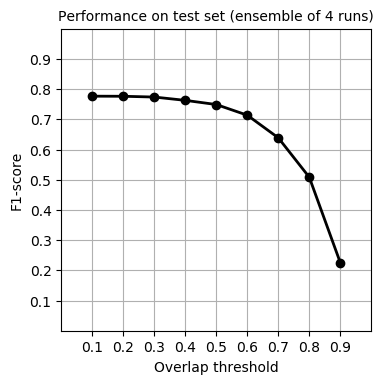

In [132]:
fig = plt.figure(figsize=(4, 4), dpi=100)
plt.plot(iou_array, f1_list, color='k', linewidth=2, markersize=12, marker='.')
plt.title('Performance on test set (ensemble of 4 runs)', fontsize=10)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.yticks([0.1*i for i in range(1, 10)])
plt.xticks([0.1*i for i in range(1, 10)])
plt.xlabel('Overlap threshold')
plt.ylabel('F1-score')
plt.grid()
plt.show()

In [133]:
be_train = [metrics.by_event_confusion(y, y_pred, iou_thr=0.3) for y, y_pred in zip(y_train, y_pred_train)]
be_val = [metrics.by_event_confusion(y, y_pred, iou_thr=0.3) for y, y_pred in zip(y_val, y_pred_val)]
be_test = [metrics.by_event_confusion(y, y_pred, iou_thr=0.3) for y, y_pred in zip(y_test, y_pred_test)]

print('BE train stats')
pprint.pprint(be_train)

print('BE val stats')
pprint.pprint(be_val)

print('BE test stats')
pprint.pprint(be_test)

BE train stats
[{'f1_score': 0.5620071684587813,
  'mean_all_iou': 0.3181929216999932,
  'mean_nonzero_iou': 0.5922944454738903,
  'n_detections': 589,
  'n_events': 806,
  'precision': 0.66553480475382,
  'recall': 0.48635235732009924,
  'tp': 392},
 {'f1_score': 0.8764155588380109,
  'mean_all_iou': 0.7217166189831489,
  'mean_nonzero_iou': 0.8394491624150369,
  'n_detections': 990,
  'n_events': 1041,
  'precision': 0.898989898989899,
  'recall': 0.8549471661863592,
  'tp': 890},
 {'f1_score': 0.853021978021978,
  'mean_all_iou': 0.7270535953966,
  'mean_nonzero_iou': 0.8154633125968267,
  'n_detections': 755,
  'n_events': 701,
  'precision': 0.8225165562913908,
  'recall': 0.8858773181169758,
  'tp': 621},
 {'f1_score': 0.8746958637469587,
  'mean_all_iou': 0.7604009321916223,
  'mean_nonzero_iou': 0.8374971378166063,
  'n_detections': 851,
  'n_events': 793,
  'precision': 0.8448883666274971,
  'recall': 0.9066834804539723,
  'tp': 719},
 {'f1_score': 0.7991021324354658,
  'mean_

In [134]:
print('Train Mean F1 score: %1.4f' % np.mean([m['f1_score'] for m in be_train]))
print('Val Mean F1 score: %1.4f' % np.mean([m['f1_score'] for m in be_val]))
print('Test Mean F1 score: %1.4f' % np.mean([m['f1_score'] for m in be_test]))

Train Mean F1 score: 0.7541
Val Mean F1 score: 0.7498
Test Mean F1 score: 0.7747


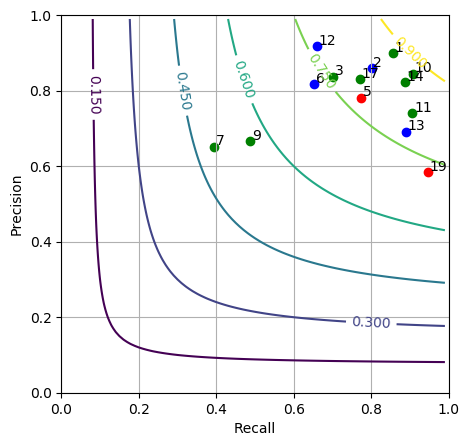

In [135]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
text_space = 0.005
# Training results
for i, stats in enumerate(be_train):
    ax.scatter(stats['recall'], stats['precision'], c='g')
    ax.annotate(train_ids[i], (stats['recall']+text_space, stats['precision']+text_space))
    
# Validation results
for i, stats in enumerate(be_val):
    ax.scatter(stats['recall'], stats['precision'], c='r')
    ax.annotate(val_ids[i], (stats['recall']+text_space, stats['precision']+text_space))
    
# Testing results
for i, stats in enumerate(be_test):
    ax.scatter(stats['recall'], stats['precision'], c='b')
    ax.annotate(test_ids[i], (stats['recall']+text_space, stats['precision']+text_space))
    

delta = 0.01 
x_ = np.arange(1, 100) * delta 
y_ = np.arange(1, 100) * delta 
X, Y = np.meshgrid(x_, y_)
Z = 2 * X * Y / (X + Y)

CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.show()

## Visualization on test set

In [174]:
# Test set  [2, 6, 12, 13]
test_set_ids = [2, 6, 12, 13]
subject_id = 2

n2_signal, n2_marks_1 = dataset.get_subject_data(subject_id, which_expert=1, verbose=True)
_, n2_marks_2 = dataset.get_subject_data(subject_id, which_expert=2, verbose=True)
pages = dataset.get_subject_pages(subject_id)

last_moment = (pages[-1]+1) * 4000

nnet = y_pred_test[test_set_ids.index(subject_id)]

Getting ID 2, 911 N2 pages, Expert 1
Getting ID 2, 911 N2 pages, Expert 2


In [179]:
nnet[0, :].max()

0.0045464244

In [184]:
def plot_page(page, signal, e1_marks, e2_marks, nnet, n2_pages, fs):
    fig = plt.figure(figsize=(10, 5), dpi=100) 
    gs = gridspec.GridSpec(4, 1, height_ratios=[4, 1, 1, 1]) 
    
    page = page - 1
    
    segment_signal = signal[page, :]
    segment_e1_marks = e1_marks[page, :]
    segment_e2_marks = e2_marks[page, :]
    segment_nn_marks = nnet[page, :]
    time_axis = np.arange(signal.shape[1])/fs
    
    # Signal
    ax0 = fig.add_subplot(gs[0])
    ax0.plot(time_axis, segment_signal, linewidth=1)
    ax0.set_yticks([])
    ax0.set_xlim([0, 20])
    ax0.set_ylim([-10, 10])
    ax0.set_title('EEG Signal, C3-CLE (intervals of 0.5s are shown), original page %d' % n2_pages[page])
    ax0.set_xticks([0, 5, 10, 15, 20])
    ax0.set_xticks(np.arange(0, 20, 0.5), minor=True)
    ax0.grid(b=True, axis='x', which='minor')
    
    # Expert mark
    ax2 = fig.add_subplot(gs[1])
    ax2.imshow(segment_e1_marks[np.newaxis, :], interpolation=None, aspect='auto', cmap='gray')
    ax2.axis('off')
    ax2.set_title('Expert 1 (white is active)')
    
    ax3 = fig.add_subplot(gs[2])
    ax3.imshow(segment_e2_marks[np.newaxis, :], interpolation=None, aspect='auto', cmap='gray')
    ax3.axis('off')
    ax3.set_title('Expert 2 (White is active)')
    
    # Neural net
    ax4 = fig.add_subplot(gs[3])
    ax4.imshow(segment_nn_marks[np.newaxis, :], interpolation=None, aspect='auto', cmap='gray', vmin=0.0, vmax=1.0)
    ax4.axis('off')
    ax4.set_title('Model probability prediction (white is active)')
    
    plt.tight_layout()
    plt.show()

In [185]:
widgets.interact(
    lambda page: plot_page(page, n2_signal, n2_marks_1, n2_marks_2, nnet, pages, dataset.fs),
    page=widgets.IntSlider(min=1,max=n2_signal.shape[0],step=1,value=1, continuous_update=False));

A Jupyter Widget

In [ ]:
# --- Particular result on test set


subject_id = 2
page = 480
fs = 200
start_time = 0
end_time = 20

n2_signal, n2_marks_1 = dataset.get_subject_data(subject_id, which_expert=1)
_, n2_marks_2 = dataset.get_subject_data(subject_id, which_expert=2)
pages = dataset.get_subject_pages(subject_id)

complete_segment = n2_signal[page, :]
time_axis = np.arange(complete_segment.size) / fs


fig = plt.figure(figsize=(10, 3), dpi=100) 
gs = gridspec.GridSpec(4, 1, height_ratios=[3, 1, 1, 3])

# fig, ax = plt.subplots(1, 1, figsize=(10, 1), dpi=100)
time_axis = np.arange(complete_segment.size) / fs
ax = fig.add_subplot(gs[0])
ax.plot(time_axis, complete_segment, linewidth=0.8)
ax.set_yticks([])
ax.set_xlim([start_time, end_time])
ax.set_ylim([-5, 5])
# ax0.set_title('EEG Signal, C3-CLE (intervals of 0.5s are shown), original page %d' % n2_pages[page])
ax.set_xticks([])
ax.set_xticks(np.arange(start_time, end_time, 0.5), minor=True)
ax.grid(b=True, axis='x', which='minor')
# plt.show()

start_sample = int(start_time*(fs))
end_sample = int(end_time*(fs))

#fig, ax = plt.subplots(1, 1, figsize=(10, 0.3), dpi=100)
ax = fig.add_subplot(gs[1])
ax.imshow(n2_marks_1[page, start_sample:end_sample][np.newaxis, :], interpolation=None, aspect='auto', extent=[0, 20, 32, 1], cmap='gray')
ax.axis('off')
# plt.show()

start_sample = int(start_time*(fs/10))
end_sample = int(end_time*(fs/10))

#fig, ax = plt.subplots(1, 1, figsize=(10, 0.3), dpi=100)
ax = fig.add_subplot(gs[2])
ax.imshow(test_preds[page, start_sample:end_sample][np.newaxis, :], interpolation=None, aspect='auto', extent=[0, 20, 32, 1], cmap='gray')
ax.axis('off')
# plt.show()
#print(test_preds[page, start_sample:end_sample])

tf.reset_default_graph()
inputs = complete_segment[np.newaxis, :]
outputs = compute_cwt(inputs, [1.5], 200, 1, 30, 32, flattening=True)
outputs = tf.layers.average_pooling2d(inputs=outputs, pool_size=(8, 1), strides=(8, 1))
# outputs = tf.log(outputs + 1e-3)

with tf.Session() as sess:
    my_cwt = sess.run(outputs)
# print(my_cwt.shape)

# fig, ax = plt.subplots(1, 1, figsize=(10, 1), dpi=100)
ax = fig.add_subplot(gs[3])
my_cwt_image = np.transpose(my_cwt[0, :, :, 0], (1, 0))
ax.imshow(my_cwt_image, interpolation=None, aspect='auto', extent=[0, 20, 32, 1])
ax.axis('off')
# ax.set_title('CWT CMorlet, [3, 40] Hz, Fb = 1.5')
plt.show()

### Comparison

In [2]:
folder = 'comparison_data'

# Chambon
convnet_data = np.loadtxt(os.path.join(folder, 'Convnet.csv'), delimiter=',')

# Expert
expert_data_mean = np.loadtxt(os.path.join(folder, 'MeanExpert.csv'), delimiter=',')
expert_data_std = np.loadtxt(os.path.join(folder, 'UpperExpert.csv'), delimiter=',')
expert_data_std[:, 1] = expert_data_std[:, 1] - expert_data_mean[:, 1]

# Proposed model
filename = 'f1_january_model_run%d.csv'
model_data = []
for n_try in [0, 1, 2, 3]:
    tmp_data = np.loadtxt(os.path.join(folder, filename % n_try), delimiter=',')
    model_data.append(tmp_data)
model_data = np.stack(model_data, axis=0)
model_data_mean = np.mean(model_data, axis=0)
model_data_mean[:, 0] = np.around(model_data_mean[:, 0], decimals=1)
model_data_std = np.std(model_data, axis=0)
model_data_std[:, 0] = model_data_mean[:, 0]

# Ensemble model
model_data_ensemble = np.loadtxt(os.path.join(folder, 'f1_january_model_ensemble.csv'), delimiter=',')
model_data_ensemble[:, 0] = np.around(model_data_ensemble[:, 0], decimals=1)

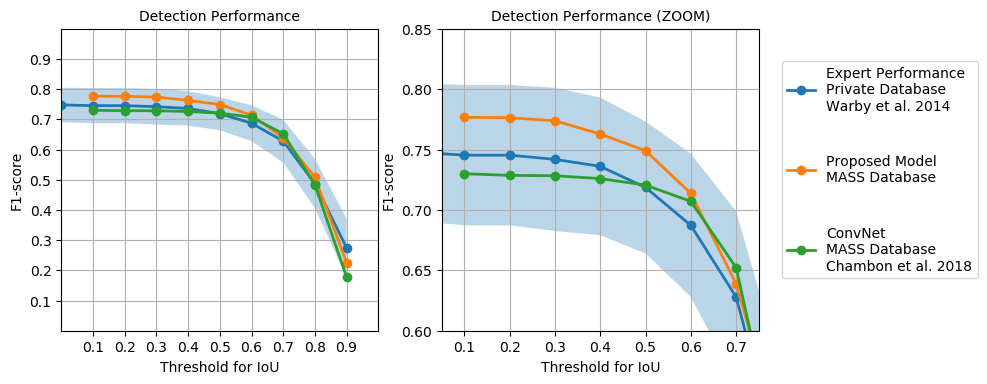

In [114]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), dpi=100)

# Complete plot
ax[0].plot(expert_data_mean[:, 0], expert_data_mean[:, 1], linewidth=2, markersize=12, marker='.', label='Expert Performance')
ax[0].fill_between(
    expert_data_mean[:, 0], 
    expert_data_mean[:, 1]-expert_data_std[:, 1], 
    expert_data_mean[:, 1]+expert_data_std[:, 1], 
    alpha=0.3)

# ax[0].plot(model_data_mean[:, 0], model_data_mean[:, 1], linewidth=2, markersize=12, marker='.', label='Proposed Model')
ax[0].plot(model_data_ensemble[:, 0], model_data_ensemble[:, 1], linewidth=2, markersize=12, marker='.', label='Proposed Model')
ax[0].plot(convnet_data[:, 0], convnet_data[:, 1], linewidth=2, markersize=12, marker='.', label='Chambon et al.')
ax[0].set_title('Detection Performance', fontsize=10)
# ax[0].axis('square')
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[0].set_yticks([0.1*i for i in range(1, 10)])
ax[0].set_xticks([0.1*i for i in range(1, 10)])
ax[0].set_xlabel('Threshold for IoU')
ax[0].set_ylabel('F1-score')
# ax[0].legend(loc='lower left')
ax[0].grid()

# Zoom plot
ax[1].plot(expert_data_mean[:, 0], expert_data_mean[:, 1], linewidth=2, markersize=12, marker='.', 
           label='Expert Performance\nPrivate Database\nWarby et al. 2014')
ax[1].fill_between(
    expert_data_mean[:, 0], 
    expert_data_mean[:, 1]-expert_data_std[:, 1], 
    expert_data_mean[:, 1]+expert_data_std[:, 1], 
    alpha=0.3)

# ax[0].plot(model_data_mean[:, 0], model_data_mean[:, 1], linewidth=2, markersize=12, marker='.', label='Proposed Model')
ax[1].plot(model_data_ensemble[:, 0], model_data_ensemble[:, 1], linewidth=2, markersize=12, marker='.', 
           label='Proposed Model\nMASS Database')
ax[1].plot(convnet_data[:, 0], convnet_data[:, 1], linewidth=2, markersize=12, marker='.', 
           label='ConvNet\nMASS Database\nChambon et al. 2018')
ax[1].set_title('Detection Performance (ZOOM)', fontsize=10)
# ax[1].axis('square')
ax[1].set_xlim([0.05, 0.75])
ax[1].set_ylim([0.6, 0.85])
# ax[1].set_yticks([0.1*i for i in range(1, 10)])
# ax[1].set_xticks([0.1*i for i in range(1, 10)])
ax[1].set_xlabel('Threshold for IoU')
ax[1].set_ylabel('F1-score')
ax[1].legend(loc='lower left', bbox_to_anchor=(1.05, 0.15), labelspacing=3)
ax[1].grid()

plt.show()

In [3]:
np.savetxt("f1_vs_iou_expert_mean.csv", expert_data_mean, delimiter=",")
np.savetxt("f1_vs_iou_expert_std.csv", expert_data_std, delimiter=",")